In [1]:
import PIL
import cv2
import geotiff
import numpy as np
from module.geoparser import SourceImage, SIFT
from module.config import CONFIG
from module.processor import Processor
import os
from module.geoparser import CropImage
from tifffile import imread as tifread
from matplotlib import pyplot as plt

In [2]:
# SIFT.setSigma(1)
# SIFT.setNOctaveLayers(2)
# SIFT.setContrastThreshold(0.3)
# SIFT.setNFeatures(1000000)
# SIFT.setEdgeThreshold(10.0)
# CONFIG.homografy_confidence = 1
CONFIG.layouts_downscale = 4
CONFIG.max_matches_to_calc_proj = 50
CONFIG

{'max_matches_to_calc_proj': 50, 'homografy_confidence': 5.0, 'data_path': 'data', 'layouts_dir_name': 'layouts', 'crops_dir_name': 'crops', 'layouts_downscale': 4, 'layout_clip_max': 2000}

In [3]:
processor = Processor()


{'min_x': 399960.0, 'max_x': 509760.0, 'min_y': 5800020.0, 'max_y': 5690220.0}
5491.3731689453125 1.0926229
{'min_x': 399960.0, 'max_x': 509760.0, 'min_y': 5800020.0, 'max_y': 5690220.0}
3664.0439453125 1.637535
{'min_x': 399960.0, 'max_x': 509760.0, 'min_y': 5800020.0, 'max_y': 5690220.0}
9454.37255859375 0.634627
{'min_x': 399960.0, 'max_x': 509760.0, 'min_y': 5800020.0, 'max_y': 5690220.0}
9021.009887695312 0.665114


In [6]:
processor.process_from_file('data/crops/crop_3_3_0000.tif')

9592.521240234375 0.5156100128561356


array([[ 438870.53031944, 5735616.34755076],
       [ 448944.69109726, 5735248.18254343],
       [ 447407.42216466, 5715070.03068671],
       [ 437333.26138684, 5715438.19569404]])

In [ ]:
layouts_dir = os.path.join(CONFIG.data_path, CONFIG.layouts_dir_name)
fig = plt.figure(figsize=(10, 7), dpi=400)
index = 1

remove_clouds = np.vectorize(lambda x: x/2000*255 if x < 2000 else 0)

for file_name in os.listdir(layouts_dir):
    fig.add_subplot(2, 2, index)
    index += 1
    image = tifread(os.path.join(layouts_dir, file_name))[:, :, 3]/2000*255
    # image = remove_clouds(image)
    # vals = image.mean(axis=1).flatten()
    # # plot histogram with 255 bins
    # b, bins, patches = plt.hist(vals, 255)
    # plt.xlim([0,255])
    # image = image.clip(0, 1)
    image = np.array(
            PIL.Image.fromarray(np.array(image, dtype=np.uint8)).resize(
                [image.shape[0] // 4, image.shape[1] // 4],
                resample=PIL.Image.BICUBIC,
            ),
            dtype=np.uint8
        )
    cv2.normalize(image, image, 50, 150, cv2.NORM_MINMAX)
    
    plt.imshow(image)
    plt.axis("off")
    plt.title(file_name)
plt.show()


In [ ]:
layouts_dir = os.path.join(CONFIG.data_path, CONFIG.layouts_dir_name)
layouts = [SourceImage(os.path.join(layouts_dir, file_name)) for file_name in os.listdir(layouts_dir)]

In [ ]:
fig = plt.figure(figsize=(10, 7), dpi=400) 
for layout in layouts:
    fig.add_subplot(2, 2, layouts.index(layout)+1) 
    plt.imshow(layout.image)
    plt.axis('off') 
    plt.title(layout.name) 
plt.show()

In [ ]:
crops_path = os.path.join(CONFIG.data_path, CONFIG.crops_dir_name)
for crop_file_name in os.listdir(crops_path):
    crop = tifread(os.path.join(crops_path, crop_file_name))
    crop = np.array(crop[:,:,:3] / 2000 * 255, dtype=np.uint8)
    crop = CropImage(crop, crop_file_name)

    print(crop_file_name)
    for layout in layouts:
        transform, _, matches = crop.match(layout)
        crop_transformed = cv2.warpPerspective(np.copy(crop.image), transform, (layout.image.shape[0], layout.image.shape[1]))
        mask = np.zeros_like(layout.image, dtype = np.uint8)
        roi_corners = np.int32([
        [
            [0, 0],
            [0, layout.image.shape[0] - 1],
            [layout.image.shape[1] - 1, layout.image.shape[0] - 1],
            [layout.image.shape[1] - 1, 0]
        ]
        ])
        ignore_mask_color = (255)
        cv2.fillPoly(mask, roi_corners, ignore_mask_color)
        img2_masked = cv2.bitwise_and(layout.image, mask)
        img_combined = cv2.add(img2_masked, crop_transformed)
        cv2.imshow('image', img_combined)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        coords = crop.get_coords(layout)
        valid = True
        for coord in coords:
            if(coord[2] > 1.2) or (coord[2] < 0.8):
                valid = False

        if(valid):
            print(coords)
        else:
            print('not valid', coords)

9592.521240234375 0.5156100128561356


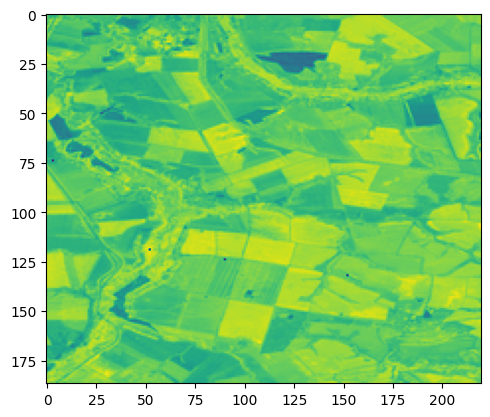

In [4]:
crop = tifread('data/crops/crop_3_3_0000.tif')
crop = crop[:,:,3:]
crop = CropImage(crop)
# crop.image = np.array(
#             PIL.Image.fromarray(crop.image).resize(
#                 [int(crop.image.shape[0] * 1.25), int(crop.image.shape[1] * 1.25)],
#                 resample=PIL.Image.BICUBIC,
#             )
#         )
plt.imshow(crop.image)

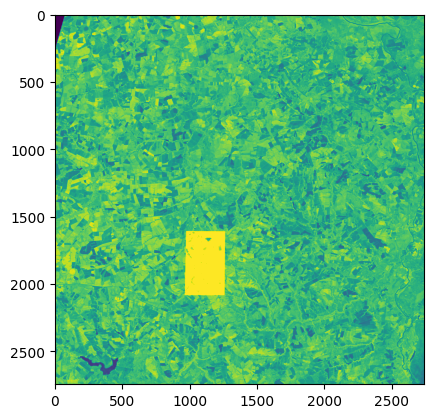

In [5]:
plt.imshow(processor.get_projectected_img(crop))

{'min_x': 399960.0, 'max_x': 509760.0, 'min_y': 5800020.0, 'max_y': 5690220.0}
5491.3731689453125 1.0926229


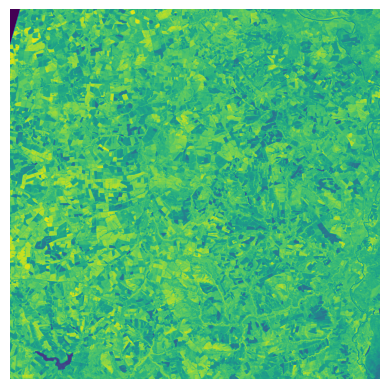

In [3]:
FILE = SourceImage('data/layouts/layout_2021-08-16.tif')
fig = plt.figure(dpi=100)
plt.imshow(FILE.image)
plt.axis("off")
plt.show()

In [17]:
np.array(FILE.coords)

array(<POLYGON ((399960 5800020, 509760 5800020, 509760 5690220, 399960 5690220, 3...>,
      dtype=object)

In [5]:
M, _, matches = crop.match(FILE)
M

array([[ 5.39337699e-01, -4.24054493e-02,  3.89406014e+02],
       [ 3.14503964e-02,  9.57822064e-01,  6.43735929e+02],
       [ 3.10629073e-05, -6.19149073e-05,  1.00000000e+00]])

[ 1.13249638e+00,  7.72778422e-02,  9.70927530e+02],
[-2.83355672e-01,  2.64994459e+00,  1.61005159e+03],
[-1.77099847e-04,  8.76687634e-05,  1.00000000e+00]]

In [6]:
img = FILE.image
sift = cv2.SIFT_create()
keypoints = FILE.keypoints
descr = FILE.descriptors
crop_keypoints = crop.keypoints
crop_descr = crop.descriptors

In [9]:
kimg = cv2.drawKeypoints(img, keypoints, np.copy(img))
cv2.imshow('image', kimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

Qt: Session management error: None of the authentication protocols specified are supported


In [7]:
kimg = cv2.drawKeypoints(crop.image, crop_keypoints, np.copy(crop.image))
cv2.imshow('image', kimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

Qt: Session management error: None of the authentication protocols specified are supported


In [7]:
# matches = bf.match(crop_descr,descr)
# matches = sorted(matches, key = lambda x:x.distance)
matched_img = cv2.drawMatches(crop.image, crop_keypoints, img, keypoints, matches[:50], img, flags=2)
cv2.imshow('image', matched_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Qt: Session management error: None of the authentication protocols specified are supported


In [12]:
crop_transformed = cv2.warpPerspective(crop.image, M, (img.shape[0], img.shape[1]))
cv2.imshow('image', crop_transformed)
cv2.waitKey(0)
cv2.destroyAllWindows()

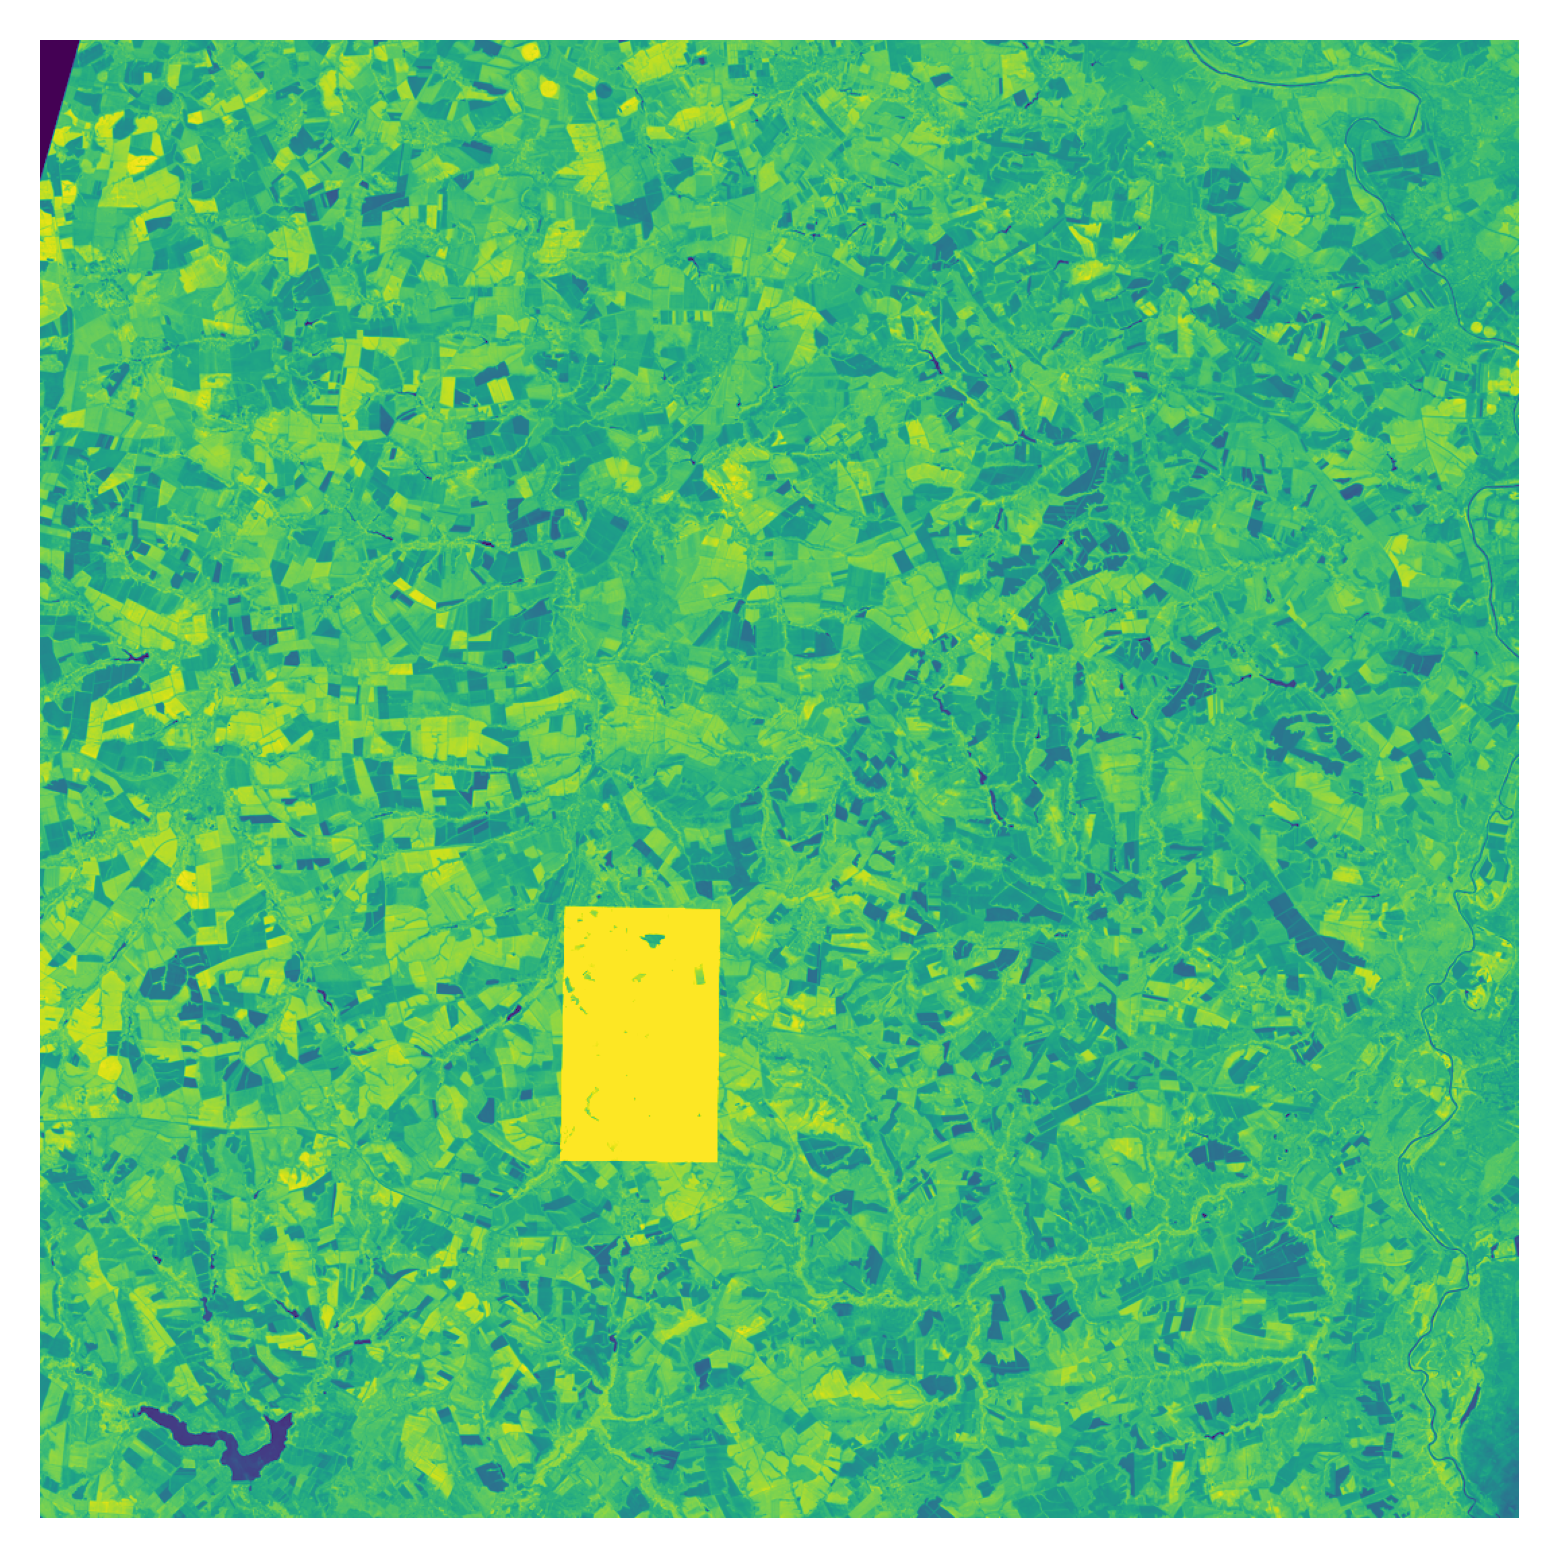

In [7]:
crop_transformed = cv2.warpPerspective(crop.image, M, (img.shape[0], img.shape[1]))
mask = np.zeros_like(img, dtype = np.uint8)
roi_corners = np.int32([
   [
      [0, 0],
      [0, img.shape[0] - 1],
      [img.shape[1] - 1, img.shape[0] - 1],
      [img.shape[1] - 1, 0]
   ]
])
ignore_mask_color = (255,)
cv2.fillPoly(mask, roi_corners, ignore_mask_color)
img2_masked = cv2.bitwise_and(img, mask)
img_combined = cv2.add(img2_masked, crop_transformed)
# cv2.imshow('image', img_combined)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
fig = plt.figure(dpi=400)
plt.imshow(img_combined)
plt.axis("off")
plt.show()


In [ ]:
left_top_corner = M.dot(np.array([0,0,1]))
right_top_corner = M.dot(np.array([crop.image.shape[0], 0, 1]))
right_bottom_corner = M.dot(np.array([crop.image.shape[0], crop.image.shape[1], 1]))
left_bottom_corner = M.dot(np.array([0, crop.image.shape[1], 1]))

print(left_top_corner, right_top_corner, right_bottom_corner, left_bottom_corner)

In [4]:
coords = crop.get_coords(FILE)
coords  

array([[ 438870.53031944, 5735616.34755076],
       [ 448944.69109726, 5735248.18254343],
       [ 447407.42216466, 5715070.03068671],
       [ 437333.26138684, 5715438.19569404]])

In [25]:
from osgeo import gdal
from tiffile import imwrite
import pyproj



imwrite('tifcrop.tif',crop.image, )
dataset: gdal.Dataset = gdal.Open('tifcrop.tif')
dataset = gdal.Translate('tifcrop1.tif', dataset, projWin=[coords[-1][0], coords[-1][0], coords[0][0], coords[0][1]])
